# Segmenting Retinal Blood Vessels With Deep Neural Networks


In [70]:
import skimage as ski
from skimage import io, exposure, data, color, data, filters, graph, measure, morphology
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
from scipy import ndimage as ndi
import cv2
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced

from image_processing import *
from functions import *

filename = 'Data/01_dr.jpg'
mask_filename = 'Data/01_dr_mask.tif'
manual_filename = 'Data/01_dr.tif'

image = loadImage(filename)
mask = loadImageTif(mask_filename)
manual = loadImageTif(manual_filename)

# Sato filter

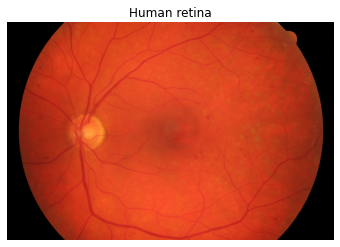

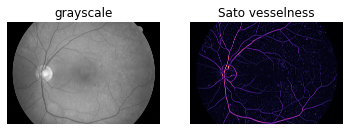

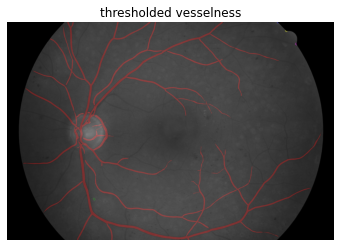

In [60]:
_, ax = plt.subplots()
ax.imshow(image)
ax.set_axis_off()
_ = ax.set_title('Human retina')

retina = color.rgb2gray(image)
t0, t1 = filters.threshold_multiotsu(retina, classes=3)
mask = (retina > t0)
vessels = filters.sato(retina, sigmas=range(1, 10)) * mask

_, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(retina, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('grayscale')
axes[1].imshow(vessels, cmap='magma')
axes[1].set_axis_off()
_ = axes[1].set_title('Sato vesselness')

thresholded = filters.apply_hysteresis_threshold(vessels, 0.01, 0.03)	#dont override vessels
labeled = ndi.label(thresholded)[0]

_, ax = plt.subplots()
ax.imshow(color.label2rgb(labeled, retina))
ax.set_axis_off()
_ = ax.set_title('thresholded vesselness')


Extract vessels from retina image


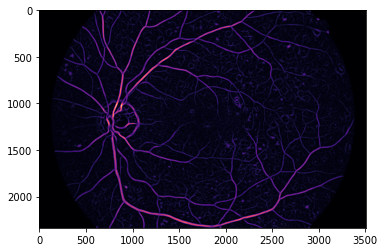

Add contrast and threshold to highlight vessels


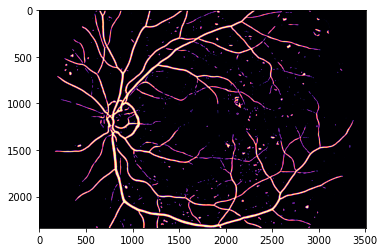

In [5]:
vessels = extract_vessels(image)
print("Extract vessels from retina image")
showImage(vessels, cmap='magma')
vessels = contrast(vessels)
vessels = threshold(vessels)
print("Add contrast and threshold to highlight vessels")
showImage(vessels, cmap='magma')

# Compare 5 images using non-machine learning methods (sato filter)



-------------------------------------------------------------------
Retina number:  1
-------------------------------------------------------------------


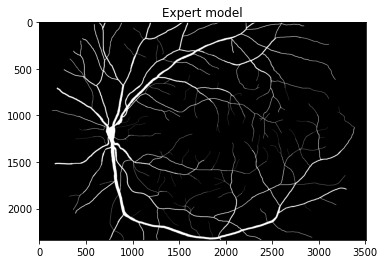

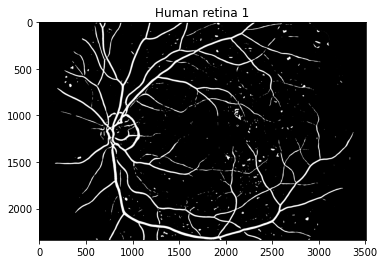

Accuracy score:		 0.959295
Sensitivity score:	 0.755060
Specificity score:	 0.970238
Precision score:	 0.576162
G-mean: 		 0.855914
Weighted average: 	 0.862649
Confusion matrix: 	 [7537842  231220  101964  314318]


-------------------------------------------------------------------
Retina number:  2
-------------------------------------------------------------------


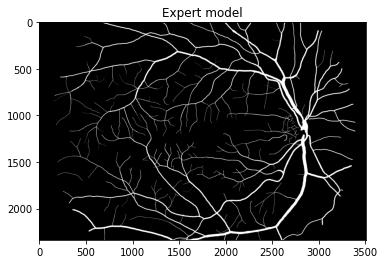

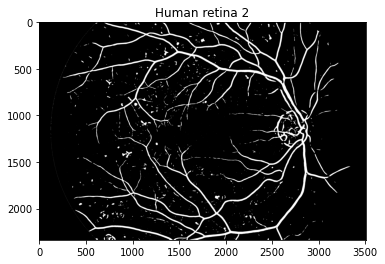

Accuracy score:		 0.955742
Sensitivity score:	 0.719289
Specificity score:	 0.971845
Precision score:	 0.635004
G-mean: 		 0.836084
Weighted average: 	 0.845567
Confusion matrix: 	 [7447700  215766  146497  375381]


-------------------------------------------------------------------
Retina number:  3
-------------------------------------------------------------------


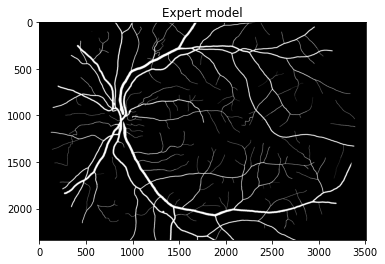

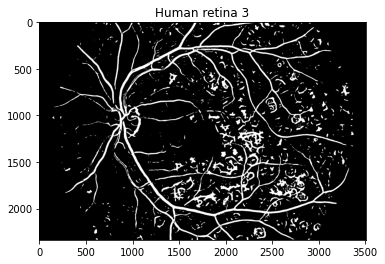

Accuracy score:		 0.921585
Sensitivity score:	 0.744557
Specificity score:	 0.932965
Precision score:	 0.416566
G-mean: 		 0.833454
Weighted average: 	 0.838761
Confusion matrix: 	 [7175378  515566  126291  368109]


-------------------------------------------------------------------
Retina number:  4
-------------------------------------------------------------------


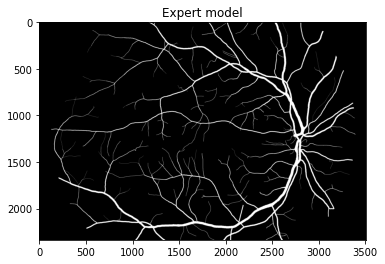

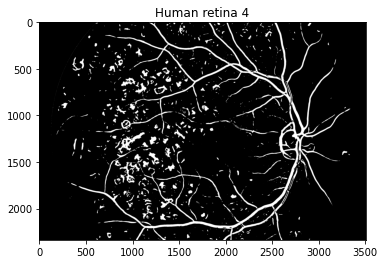

Accuracy score:		 0.937877
Sensitivity score:	 0.680282
Specificity score:	 0.953292
Precision score:	 0.465698
G-mean: 		 0.805300
Weighted average: 	 0.816787
Confusion matrix: 	 [7362435  360730  147767  314412]


-------------------------------------------------------------------
Retina number:  5
-------------------------------------------------------------------


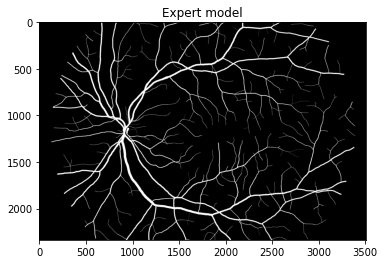

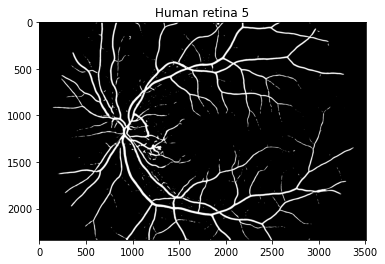

Accuracy score:		 0.963099
Sensitivity score:	 0.789136
Specificity score:	 0.974633
Precision score:	 0.673490
G-mean: 		 0.876994
Weighted average: 	 0.881885
Confusion matrix: 	 [7481643  194723  107325  401653]


-------------------------------------------------------------------
Retina number:  6
-------------------------------------------------------------------


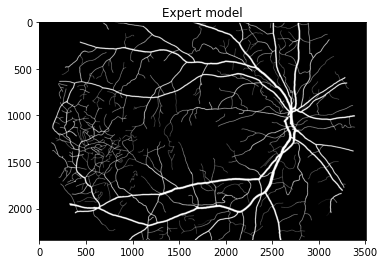

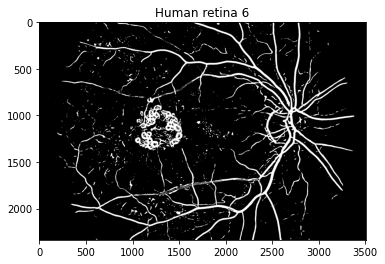

Accuracy score:		 0.936344
Sensitivity score:	 0.642916
Specificity score:	 0.960306
Precision score:	 0.569460
G-mean: 		 0.785745
Weighted average: 	 0.801611
Confusion matrix: 	 [7266999  300379  220666  397300]


In [5]:
number_of_images = 5

for number in range(1,number_of_images+2):
	# import files
	filenameN = 'Data/0' + str(number) + '_dr.jpg'
	mask_filenameN = 'Data/0' + str(number) + '_dr_mask.tif'
	manual_filenameN = 'Data/0' + str(number) + '_dr.tif'	
	imageN = loadImage(filenameN)
	maskN = loadImageTif(mask_filenameN)
	manualN = loadImageTif(manual_filenameN)

	vesselsN = extract_and_use_vessels(imageN)

	print("\n\n-------------------------------------------------------------------")
	print("Retina number: ", number)
	print("-------------------------------------------------------------------")
	showImage(manualN, title="Expert model")
	showImage(vesselsN, title="Human retina "+str(number))

	stats = {}
	stats['accuracy'], stats['sensitivity'], stats['specificity'], stats['precision'], stats['g_mean'], stats['w_average'], stats['c_matrix'] = get_metrics(vesselsN, manualN)
	show_stats(stats)

# REST

In [ ]:
both_vessels = np.logical_and(vessels, manual)
wrong_vessels = np.logical_xor(vessels, manual)
all_vessels = np.logical_or(vessels, manual)
print("Sensitivity:" , round(sum(both_vessels.flatten() + sum(wrong_vessels.flatten())) / sum(all_vessels.flatten())*100, 3), "%")

In [1]:
from os import listdir
import os
import re

filename = 'Data/01_dr.jpg'
mask_filename = 'Data/01_dr_mask.tif'
manual_filename = 'Data/01_dr.tif'

# print(''.join(re.findall(r"[0-90-9]", filename)))

def get_image_paths(endings: str):
	paths = []
	for i in range(1, 6):
		filenameN = 'Data/0' + str(i) + endings
		paths.append(filenameN)
	print(paths)
	return sorted(paths)

def get_features(image: np.ndarray) -> np.ndarray:  # TODO

    image_gray = color.rgb2gray(image)
    features = image_gray.flatten()
    return features

def get_input_features(data_images: list) -> np.ndarray:
    features = [get_features(image) for image in data_images]
    # features = np.stack(np.asarray(features), axis=1)[0]
    features = np.stack(np.asarray(features), axis=0)
    # features = np.array(features)
    # features.reshape(len(data_images), features.shape[2])
    return features

def get_center_value(image: np.ndarray) -> float:  # TODO
    n = image.size
    if n % 2 == 0:
        raise Exception("Can't get image center value!")

    val = np.take(image, n // 2)
    val = np.heaviside(val, 0)
    return val

def get_target_vals(target_images: list) -> list:
    vals = [get_center_value(image) for image in target_images]
    return vals
# def load_image(path: str, as_arr: bool = False):
#     img = open(path)
#     if as_arr:
#         return np.asarray(img)
#     else:
#         return img
    

def slice_image(image: np.ndarray, slice_size: int) -> list:
    width, height = image.shape[0], image.shape[1]
    offset = slice_size//2

    if len(image.shape) == 3:
        sliced_image = np.zeros((width+2*offset, height+2*offset, 3))
    else:
        sliced_image = np.zeros((width+2*offset, height+2*offset))

    sliced_image[offset:height+offset, offset:width+offset] = image
    slices = []
    for i in range(height):
        for j in range(width):
            img_temp = sliced_image[i:i+slice_size, j:j+slice_size]
            slices.append(img_temp)
    return slices


def get_list_slices(image_list: list, slice_size) -> list:
    slices = []
    for image in image_list:
        image_slices = slice_image(image, slice_size)
        for img in image_slices:
            slices.append(img)
    return slices

# ładuj obrazki 
def load_sliced_images(image_shape = (256, 256), slice_size: int = 9):

    data_paths, target_paths = get_image_paths('_dr.jpg'), get_image_paths('_dr.tif')

    data_images = [cv2.resize(loadImage(path), image_shape) for path in data_paths]
    data_slices = get_list_slices(data_images, slice_size)

    target_images = [cv2.resize(loadImage(path), image_shape) for path in target_paths]
    target_slices = get_list_slices(target_images, slice_size)

    return data_slices, target_slices

def init_knn_classifier(training_data, true_values) -> KNeighborsClassifier:

    classifier = KNeighborsClassifier(n_neighbors=4)
    classifier.fit(training_data, true_values)

    return classifier

NameError: name 'np' is not defined

# Machine learning

### Wymagania na 4.0


Po wstępnym przetworzeniu obrazu należy podzielić go na wycinki (np. 5x5 px) i dla każdej z nich dokonać ekstrakcji cech z obrazu: np. wariancja kolorów, momenty centralne, momenty Hu itp. Wartości te wraz z informacją pochodzącą z maski eksperckiej (decyzja dla środkowego piksela wycinka) stanowić będą zbiór danych wykorzystany do budowy wybranego klasyfikatora, prostszego niż głęboka sieć neuronowa (np. kNN, drzewo lub las decyzyjny, SVM). Należy skorzystać z gotowej implementacji klasyfikatora (np. w bibliotece scikit-learn).


Z uwagi na ograniczenia pamięciowe konieczne może być ograniczenie rozmiaru zbioru uczącego poprzez losowy wybór punktów (możliwość zastosowania undersampling-u do zrównoważenia rozkładu klas w zbiorze uczącym).


Zdolności predykcyjne tak opracowanego klasyfikatora należy wstępnie zweryfikować na niezależnym zbiorze testowym hold-out (np. pochodzącym z innej części obrazu lub z innego obrazu). 


Gotowy klasyfikator powinien zostać osadzony w aplikacji, a jego działanie powinno zostać zwizualizowane i przetestowane w taki sam sposób, jak działanie technik przetwarzania obrazu z wymagań podstawowych.


In [54]:
import os
slice_size = 15

data_images, target_images = load_sliced_images(slice_size=slice_size)

train_data_images, test_data_images, train_target_images, test_target_images = train_test_split(data_images, target_images, test_size=0.3, random_state=42)

train_data, train_target = get_input_features(train_data_images), get_target_vals(train_target_images)
test_data, test_target = get_input_features(test_data_images), get_target_vals(test_target_images)

classifier = init_knn_classifier(train_data, train_target)


['Data/01_dr.jpg', 'Data/02_dr.jpg', 'Data/03_dr.jpg', 'Data/04_dr.jpg', 'Data/05_dr.jpg']
['Data/01_dr.tif', 'Data/02_dr.tif', 'Data/03_dr.tif', 'Data/04_dr.tif', 'Data/05_dr.tif']


In [55]:
j = 3000
predictions = classifier.predict(test_data[0:j])

tp, fp, fn, tn = 0, 0, 0, 0
for pred, targ in zip(predictions, test_target[:j]):
    if pred:
        if targ:
            tp += 1
        else:
            fp += 1
    else:
        if targ:
            fn += 1
        else:
            tn += 1

accuracy = (tp + tn) / (tn + fn + tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
geometric = float(gmean([sensitivity, specificity]))

stats = [accuracy, sensitivity, specificity, geometric]

stat_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Geometric']
for i, name in enumerate(stat_names):
    print(f"{name}: {stats[i]}")

Accuracy: 0.9483333333333334
Sensitivity: 0.32242990654205606
Specificity: 0.9964106245513281
Geometric: 0.5668091253249161


1.0


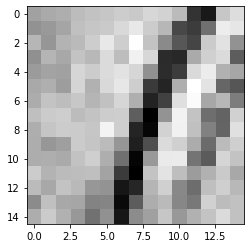

In [56]:
j, s = 0, 0
shift = 33
while predictions[j] != 1 or s < shift:
    j += 1
    s += 1

img = test_data[j]
m = np.sqrt(img.size).astype('int32')
img = img.reshape((m, m))
print(predictions[j])
plt.imshow(img, cmap='gray')

In [58]:
i = 9
input_img = np.asarray(loadImage(filename))
input_slices = get_input_features(data_images[256*256*(i):256*256*(i+1)])
target_img = np.asarray(loadImage(filename))

ValueError: need at least one array to stack

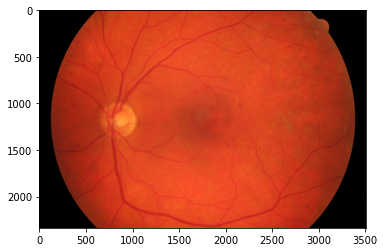

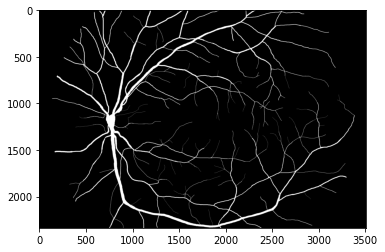

In [44]:
showImage(image)
showImage(manual)
pieces_size = 5
features = []
for i in range(0, image.shape[0], 5):
	for j in range(615, image.shape[1], 5):
		mini_fragment = image[i:i+pieces_size, j:j+pieces_size, :]
		
		# wariancja kolorów
		variance_g = np.var(mini_fragment[:, :, 1])  # wariancja kolorów dla kanału G
		# print("Fragment: ", i, j, "Variance: ", variance_r, variance_g, variance_b)

		# momenty 
		M_green = cv2.moments(mini_fragment[:,:,1])
		# print("Cx: ", M_red['m10']/M_red['m00'])
		# print("Cy: ", M_red['m01']/M_red['m00'])
		# print("Cx: ", M_green['m10']/M_green['m00'])
		# print("Cy: ", M_green['m01']/M_green['m00'])
		# print("Cx: ", M_blue['m10']/M_blue['m00'])
		# print("Cy: ", M_blue['m01']/M_blue['m00'])

		# momenty hu
		huMoments_green = cv2.HuMoments(M_green)
		# print("Hu moments red: ", huMoments_red)
		# print("Hu moments green: ", huMoments_green)
		# print("Hu moments blue: ", huMoments_blue)

		featureVector = [variance_g, M_green, huMoments_green]
		features.append(featureVector)

print("Features: ", features)
# # klasyfikacja
# label = manual[i+fragments//2, j+fragments//2]


# print("Class: ", clf.predict([[variance_r, variance_g, variance_b]]))

		

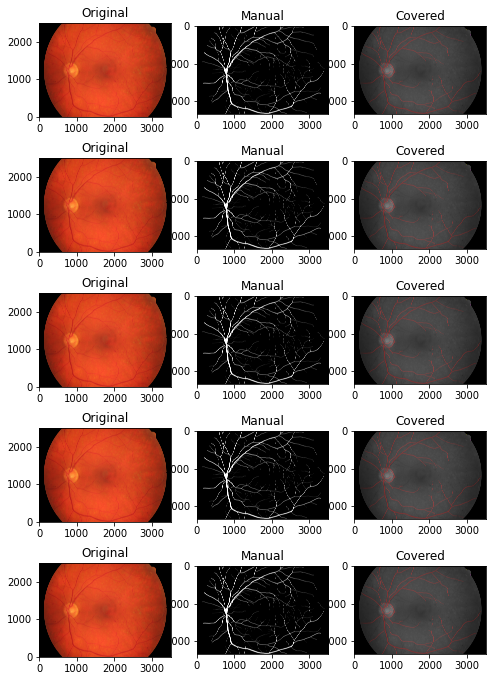

In [69]:
h, w = 100, 100      # for raster image
nrows, ncols = 5, 3  # array of sub-plots
figsize = [8, 12]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
	# i runs from 0 to (nrows*ncols-1)
	# axi is equivalent with ax[rowid][colid]
	img = np.random.randint(10, size=(h,w))
	if i%3==0: 
		axi.imshow(image, cmap='gray', extent=[0, 3500, 0, 2500])
		axi.set_title("Original")
	elif i%3==1: 
		axi.imshow(manual, cmap='gray')
		axi.set_title("Manual")
	else:
		axi.imshow(color.label2rgb(labeled, retina))
		axi.set_title("Covered")
	rowid = i // ncols
	colid = i % ncols


plt.show()
fig.savefig("Sato filtering.png")
